<a href="https://colab.research.google.com/github/BeefMILF/dls_school2/blob/master/QA_project/Copy_of_QA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Проект QA

## Yes/No Questions

Вы будете работать с корпусом BoolQ. Корпус состоит из вопросов, предполагающих бинарный ответ (да / нет), абзацев из Википедии,  содержащих ответ на вопрос, заголовка статьи, из которой извлечен абзац и непосредственно ответа (true / false).

Корпус описан в статье:

Christopher Clark, Kenton Lee, Ming-Wei Chang, Tom Kwiatkowski, Michael Collins, Kristina Toutanova
BoolQ: Exploring the Surprising Difficulty of Natural Yes/No Questions

https://arxiv.org/abs/1905.10044


Корпус (train-dev split) доступен в репозитории проекта:  https://github.com/google-research-datasets/boolean-questions

Используйте для обучения train часть корпуса, для валидации и тестирования – dev часть. 

Каждый бонус пункт оцениватся в 1 балл. 

In [0]:
!gsutil cp gs://boolq/train.jsonl .
!gsutil cp gs://boolq/dev.jsonl .

Copying gs://boolq/train.jsonl...
/ [1 files][  6.2 MiB/  6.2 MiB]                                                
Operation completed over 1 objects/6.2 MiB.                                      
Copying gs://boolq/dev.jsonl...
/ [1 files][  2.1 MiB/  2.1 MiB]                                                
Operation completed over 1 objects/2.1 MiB.                                      


### Пример вопроса: 
question: is batman and robin a sequel to batman forever

title: Batman & Robin (film)

answer: true

passage: With the box office success of Batman Forever in June 1995, Warner Bros. immediately commissioned a sequel. They hired director Joel Schumacher and writer Akiva Goldsman to reprise their duties the following August, and decided it was best to fast track production for a June 1997 target release date, which is a break from the usual 3-year gap between films. Schumacher wanted to homage both the broad camp style of the 1960s television series and the work of Dick Sprang. The storyline of Batman & Robin was conceived by Schumacher and Goldsman during pre-production on A Time to Kill. Portions of Mr. Freeze's back-story were based on the Batman: The Animated Series episode ''Heart of Ice'', written by Paul Dini.

## Часть 1. Эксплоративный анализ
1. Посчитайте долю yes и no классов в корпусе
2. Оцените среднюю длину вопроса
3. Оцените среднюю длину параграфа
4. Предположите, по каким эвристикам были собраны вопросы (или найдите ответ в статье). Продемонстриуйте, как эти эвристики повлияли на структуру корпуса. 

## Часть 2. Baseline
1. Оцените accuracy точность совсем простого базового решения: присвоить каждой паре вопрос-ответ в dev части самый частый класс из train части
2. Оцените accuracy чуть более сложного базового решения: fasttext на текстах, состоящих из склееных вопросов и абзацев (' '.join([question, passage]))

Почему fasttext плохо справляется с этой задачей?

## Часть 3. Используем эмбеддинги предложений
1. Постройте BERT эмбеддинги вопроса и абзаца. Обучите логистическую регрессию на конкатенированных эмбеддингах вопроса и абзаца и оцените accuracy этого решения. 

[bonus] Используйте другие модели эмбеддингов, доступные, например, в библиотеке 🤗 Transformers. Какая модель эмбеддингов даст лучшие результаты?

[bonus] Предложите метод аугментации данных и продемонстрируйте его эффективность. 

## Часть 3. DrQA-подобная архитектура

Основана на статье: Reading Wikipedia to Answer Open-Domain Questions

Danqi Chen, Adam Fisch, Jason Weston, Antoine Bordes

https://arxiv.org/abs/1704.00051

Архитектура DrQA предложена для задачи SQuAD, но легко может быть адаптирована к текущему заданию. Модель состоит из следующих блоков:
1. Кодировщик абзаца [paragraph encoding] – LSTM, получаящая на вход вектора слов, состоящие из: 
* эмбеддинга слова (w2v или fasttext)
* дополнительных признаков-индикаторов, кодирующих в виде one-hot векторов часть речи слова, является ли оно именованной сущностью или нет, встречается ли слово в вопросе или нет 
* выровненного эмбеддинга вопроса, получаемого с использованием soft attention между эмбеддингами слов из абзаца и эмбеддингом вопроса.

$f_{align}(p_i) = \sum_j􏰂 a_{i,j} E(q_j)$, где $E(q_j)$ – эмбеддинг слова из вопроса. Формула для $a_{i,j}$ приведена в статье. 

2. Кодировщик вопроса [question encoding] – LSTM, получаящая на вход эмбеддинги слов из вопроса. Выход кодировщика: $q = 􏰂\sum_j􏰂  b_j q_j$. Формула для $b_{j}$ приведена в статье. 

3. Слой предсказания. 

Предложите, как можно было модифицировать последний слой предсказания в архитектуре DrQA, с учетом того, что итоговое предсказание – это метка yes / no, предсказание которой проще, чем предсказание спана ответа для SQuAD.

Оцените качество этой модели для решения задачи. 

[bonus] Замените входные эмбеддинги и все дополнительные признаки, используемые кодировщиками, на BERT эмбеддинги. Улучшит ли это качество результатов?

## Часть 4. BiDAF-подобная архитектура

Основана на статье: Bidirectional Attention Flow for Machine Comprehension

Minjoon Seo, Aniruddha Kembhavi, Ali Farhadi, Hannaneh Hajishirzi

https://arxiv.org/abs/1611.01603

Архитектура BiDAF предложена для задачи SQuAD, но легко может быть адаптирована к текущему заданию. Модель состоит из следующих блоков:
1. Кодировщик  получает на вход два представления слова: эмбеддинг слова и полученное из CNN посимвольное представление слова. Кодировщики для вопроса и для параграфа одинаковы. 
2. Слой внимания (детальное описание приведено в статье, см. пункт Attention Flow Layer)
3. Промежуточный слой, который получает на вход контекстуализированные эмбеддинги слов из параграфа, состоящие из трех частей (выход кодировщика параграфа,   Query2Context (один вектор) и Context2Query (матрица) выравнивания

4. Слой предсказания. 

Предложите, как можно было модифицировать последний слой предсказания в архитектуре BiDAF, с учетом того, что итоговое предсказание – это метка yes / no, предсказание которой проще, чем предсказание спана ответа для SQuAD.

Оцените качество этой модели для решения задачи. 

[bonus] Замените входные эмбеддинги и все дополнительные признаки, используемые кодировщиками, на BERT эмбеддинги. Улучшит ли это качество результатов?

Сравнение DrQA и BiDAF:
    
![](https://www.researchgate.net/profile/Felix_Wu6/publication/321069852/figure/fig1/AS:560800147881984@1510716582560/Schematic-layouts-of-the-BiDAF-left-and-DrQA-right-architectures-We-propose-to.png)

## Часть 5. Итоги
Напишите краткое резюме проделанной работы. Сравните результаты всех разработанных моделей. Что помогло вам в выполнении работы, чего не хватало?

### Load data

In [0]:
!gsutil cp gs://boolq/train.jsonl .
!gsutil cp gs://boolq/dev.jsonl .

### Installation 

***transformers***

In [2]:
pip install transformers

***fasttext***

In [3]:
# !git clone https://github.com/facebookresearch/fastText.git

fatal: destination path 'fastText' already exists and is not an empty directory.


In [4]:
# cd fastText

/content/fastText


In [0]:
# pip install .

In [6]:
# cd .. 

/content


***catalyst***

In [0]:
pip install -U catalyst

***FP16***, float16 format for faster training

In [3]:
# if Your machine doesn't support FP16, comment these 4 lines below
!git clone https://github.com/NVIDIA/apex 
!pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./apex 
!rm -rf ./apex
FP16_PARAMS = dict(opt_level="O1") 
# FP16_PARAMS = None

Cloning into 'apex'...
remote: Enumerating objects: 7255, done.
remote: Total 7255 (delta 0), reused 0 (delta 0), pack-reused 7255
Receiving objects: 100% (7255/7255), 13.85 MiB | 23.26 MiB/s, done.
Resolving deltas: 100% (4901/4901), done.
/usr/local/lib/python3.6/dist-packages/pip/_internal/commands/install.py:283: UserWarning: Disabling all use of wheels due to the use of --build-options / --global-options / --install-options.
  cmdoptions.check_install_build_global(options)
Created temporary directory: /tmp/pip-ephem-wheel-cache-5wemcabt
Created temporary directory: /tmp/pip-req-tracker-pnjbbsqb
Created requirements tracker '/tmp/pip-req-tracker-pnjbbsqb'
Created temporary directory: /tmp/pip-install-1rw4ik8h
Processing ./apex
  Created temporary directory: /tmp/pip-req-build-vrif970l
  Added file:///content/apex to build tracker '/tmp/pip-req-tracker-pnjbbsqb'
    Running setup.py (path:/tmp/pip-req-build-vrif970l/setup.py) egg_info for package from file:///content/apex
    Runnin

### Imports 

In [3]:
import random 

# Numpy & Pandas 
import numpy as np 
import pandas as pd 

from tqdm.notebook import tqdm

# Matplotlib & Seaborn
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set()

# Sklearn 
from sklearn.metrics import accuracy_score

# PyTorch 
import torch
from torch import nn 
from torch.nn import functional as F 
from torch.utils.data import TensorDataset, DataLoader, Dataset, RandomSampler, SequentialSampler, WeightedRandomSampler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# FastText
import fasttext

# Transformers 
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Catalyst
from catalyst.dl import SupervisedRunner
from catalyst.dl.callbacks import AccuracyCallback, F1ScoreCallback, OptimizerCallback
from catalyst.dl.callbacks import CheckpointCallback, InferCallback
from catalyst.utils import set_global_seed, prepare_cudnn
from catalyst.dl import utils
from catalyst.data import BalanceClassSampler

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject



### Read json 

In [4]:
# Loading data
df_train = pd.read_json("/content/train.jsonl", lines=True, orient='records')
df_dev = pd.read_json("/content/dev.jsonl", lines=True, orient="records")

print(f'Train df size: {df_train.shape}')
print(f'Dev df size: {df_dev.shape}')

Train df size: (9427, 4)
Dev df size: (3270, 4)


In [5]:
df_train.head(2)

,question,title,answer,passage
0,do iran and afghanistan speak the same language,Persian language,True,"Persian (/ˈpɜːrʒən, -ʃən/), also known by its ..."
1,do good samaritan laws protect those who help ...,Good Samaritan law,True,Good Samaritan laws offer legal protection to ...


## Task 1 

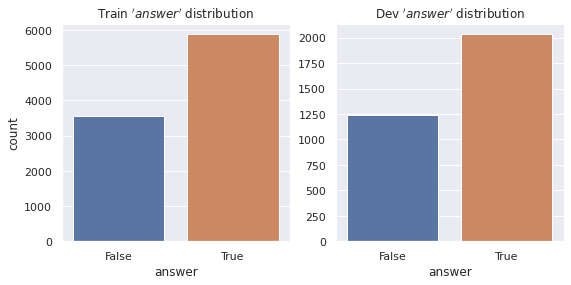

In [0]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4))
sns.countplot(x='answer', data=df_train, ax=ax[0])
sns.countplot(x='answer', data=df_dev, ax=ax[1])

# switch off ylabel 
ax[1].set_ylabel('')    

ax[0].set_title('Train $\'answer\'$ distribution')
ax[1].set_title('Dev $\'answer\'$ distribution')

plt.show()

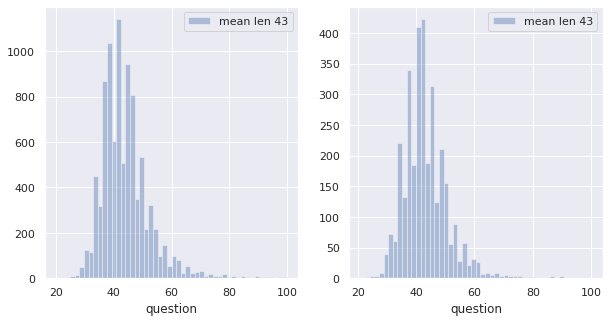

In [0]:
qlen_train_mean = int(df_train.question.str.len().mean())
qlen_dev_mean = int(df_dev.question.str.len().mean())

f, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot a simple histogram with binsize determined automatically
ax1 = sns.distplot(df_train.question.str.len(), kde=False, color="b", label=f'mean len {qlen_train_mean}', ax=axes[0])
ax2 = sns.distplot(df_dev.question.str.len(), kde=False, color="b", label=f'mean len {qlen_dev_mean}', ax=axes[1])

ax1.legend()
ax2.legend()

f.show()

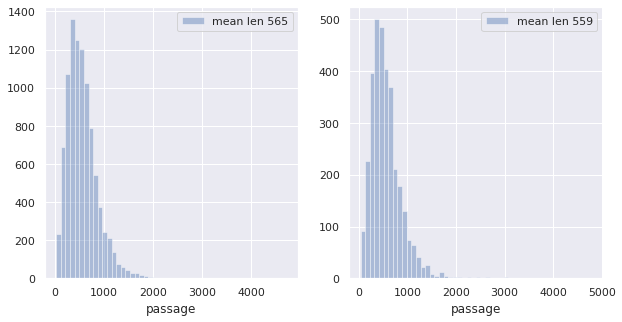

In [0]:
qlen_train_mean = int(df_train.passage.str.len().mean())
qlen_dev_mean = int(df_dev.passage.str.len().mean())

f, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot a simple histogram with binsize determined automatically
ax1 = sns.distplot(df_train.passage.str.len(), kde=False, color="b", label=f'mean len {qlen_train_mean}', ax=axes[0])
ax2 = sns.distplot(df_dev.passage.str.len(), kde=False, color="b", label=f'mean len {qlen_dev_mean}', ax=axes[1])

ax1.legend()
ax2.legend()

f.show()

## Task 2 

### Baseline model, predicting the most frequent class 

Train accuracy: <mark>0.6231</mark>

Dev accuracy: <mark>0.6217</mark>

In [0]:
base_answer = df_train.answer.value_counts().idxmax()

train_preds = np.repeat(base_answer, len(df_train))
dev_preds = np.repeat(base_answer, len(df_dev))

print(f'Train accuracy: {accuracy_score(df_train.answer, train_preds):.4f}')
print(f'Dev accuracy: {accuracy_score(df_dev.answer, dev_preds):.4f}')

Train accuracy: 0.6231
Dev accuracy: 0.6217


### Fasttext model

***Resourses:***

* [fasttext python usage](https://fasttext.cc/docs/en/supervised-tutorial.html)
* [fasttext with command line](https://gosha20777.github.io/tutorial/2018/04/12/fasttext-for-windows/)



* *Model 1.* `wordNgrams=2, epoch=15`

Train accuracy: <mark>0.9275</mark>

Dev accuracy: <mark>0.6853</mark>

* *Model 2.* `wordNgrams=3, epoch=10, lr=0.2, dim=50`

Train accuracy: <mark>0.9567</mark>

Dev accuracy: <mark>0.6945</mark>

In [0]:
train_tgt = '__label__' + df_train.answer.astype(str)
dev_tgt = '__label__' + df_dev.answer.astype(str)

train_data = df_train[['question', 'passage']].apply(lambda r: ' '.join(r), axis=1)
dev_data = df_dev[['question', 'passage']].apply(lambda r: ' '.join(r), axis=1)

print(f'Train total lines: {len(train_data)}')
print(f'Dev total lines: {len(dev_data)}')

np.savetxt('train.txt', (train_tgt + ' ' + train_data).values, delimiter=" ", fmt="%s") 
np.savetxt('dev.txt', dev_data, delimiter=" ", fmt="%s") 

train_tgt = train_tgt.values 
dev_tgt = dev_tgt.values

train_data = train_data.values
dev_data = dev_data.values 

Train total lines: 9427
Dev total lines: 3270


In [0]:
def fit_fasttext(path, train_data, dev_data, train_tgt, dev_tgt, **kwargs): 
    # model without parameters performed ~ 0.67 on dev data 
    model = fasttext.train_supervised(input="train.txt", **kwargs)

    train_preds = np.array([model.predict(row)[0][0] for row in train_data]) 
    dev_preds = np.array([model.predict(row)[0][0] for row in dev_data]) 

    print(f'Train accuracy: {accuracy_score(train_preds, train_tgt):.4f}')
    print(f'Dev accuracy: {accuracy_score(dev_preds, dev_tgt):.4f}')


# first variant 
fit_fasttext('train.txt', train_data, dev_data, train_tgt, dev_tgt, 
             wordNgrams=2, epoch=15)

print() 
# second variant 
fit_fasttext('train.txt', train_data, dev_data, train_tgt, dev_tgt, 
             wordNgrams=3, epoch=10, lr=0.2, dim=50)

Train accuracy: 0.9275
Dev accuracy: 0.6853

Train accuracy: 0.9567
Dev accuracy: 0.6945


## Task 3 

### Data encoding 

In [36]:
def encode_data(tokenizer, questions, passages, max_length):
    """Encode the question/passage pairs into features than can be fed to the model."""
    input_ids = []
    attention_masks = []

    for question, passage in tqdm(zip(questions, passages)):
        encoded_data = tokenizer.encode_plus(question, passage, max_length=max_length, pad_to_max_length=True, truncation_strategy="longest_first")
        encoded_pair = encoded_data["input_ids"]
        attention_mask = encoded_data["attention_mask"]

        input_ids.append(encoded_pair)
        attention_masks.append(attention_mask)

    return np.array(input_ids), np.array(attention_masks)


# Set seeds for reproducibility
random.seed(33)
np.random.seed(33)
torch.manual_seed(33)

# Pretrained tokenizer 
pretrained_model_name = 'roberta-base'
# pretrained_model_name = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name) 


passages_train = df_train.passage.values
questions_train = df_train.question.values
answers_train = df_train.answer.values.astype(int)

passages_dev = df_dev.passage.values
questions_dev = df_dev.question.values
answers_dev = df_dev.answer.values.astype(int)

# Encoding data
max_seq_length = 256

input_ids_train, attention_masks_train = encode_data(tokenizer, questions_train, passages_train, max_seq_length)
input_ids_dev, attention_masks_dev = encode_data(tokenizer, questions_dev, passages_dev, max_seq_length)

train_features = (input_ids_train, attention_masks_train, answers_train)
dev_features = (input_ids_dev, attention_masks_dev, answers_dev)

print(f'Train params size,  input ids: {input_ids_train.shape}, attention masks: {attention_masks_train.shape} , answers(targets): {answers_train.shape}')
print(f'Dev params size,  input ids: {input_ids_dev.shape}, attention masks: {attention_masks_dev.shape} , answers(targets): {answers_dev.shape}')

# Split Dev into test/val 
test_val_inds = np.random.choice(2, len(answers_dev), p=[0.3, 0.7]).astype(bool)
test_features = [feature[~test_val_inds] for feature in dev_features]
val_features =  [feature[test_val_inds] for feature in dev_features]

print(f'Test params size,  input ids: {test_features[0].shape}, attention masks: {test_features[1].shape} , answers(targets): {test_features[2].shape}')
print(f'Validation params size,  input ids: {val_features[0].shape}, attention masks: {val_features[1].shape} , answers(targets): {val_features[2].shape}')

print('Sample: ')
input_ids_train[0], attention_masks_train[0], answers_train[0]


Train params size,  input ids: (9427, 256), attention masks: (9427, 256) , answers(targets): (9427,)
Dev params size,  input ids: (3270, 256), attention masks: (3270, 256) , answers(targets): (3270,)
Test params size,  input ids: (994, 256), attention masks: (994, 256) , answers(targets): (994,)
Validation params size,  input ids: (2276, 256), attention masks: (2276, 256) , answers(targets): (2276,)
Sample: 


(array([    0,   109, 10209,   260,     8,  9724,  5158,  7566,  1994,
            5,   276,  2777,     2,     2, 27775, 48229, 49066,   642,
        35423,    48, 43621, 16948,   338, 38155, 10659, 35423,    27,
          282,     6,   111, 38155,   862, 35423,    27,   282,    73,
          238,    67,   684,    30,    63,   253, 41433,   274,  2726,
          118,    36, 26068, 10172, 29438, 29434, 40637, 44148, 14285,
          856, 18195,  4926,   118,    36,   506, 35423, 10659, 43621,
        16948, 35423,  4726, 49066, 11000, 43621, 16948,    43,    36,
         4161, 46934,    16,    65,     9,     5,  2027,  5051, 11991,
          624,     5, 27617,    12, 21336,   811,  6084,     9,     5,
        27617,    12, 17108,  2777,   284,     4,    85,    16,  4212,
         5826,    11,  1603,     6,  4035,    36, 27257, 11416,   684,
           25,   211,  1512,   187, 23102,   238,     8, 17335,   967,
         7566,    36, 27257, 11416,   684,    25, 17335,  8907,   187,
      

In [0]:
# Same data encoding, but works longer  

# enc_data = df_train[['question', 'passage']].apply(lambda x: get_attrs(tokenizer.encode_plus(*x.values, max_length=256, pad_to_max_length=True, truncation_strategy="longest_first")), axis=1)
# train_features = (enc_data.apply(lambda x: x[0]).values, enc_data.apply(lambda x: x[1]).values, df_train.answer.values.astype(int))

# enc_data = df_dev[['question', 'passage']].apply(lambda x: get_attrs(tokenizer.encode_plus(*x.values, max_length=256, pad_to_max_length=True, truncation_strategy="longest_first")), axis=1)
# train_features = (enc_data.apply(lambda x: x[0]).values, enc_data.apply(lambda x: x[1]).values, df_dev.answer.values.astype(int))

### Prepare loaders 

In [37]:
class BQDataset(Dataset): 
    def __init__(self, data):
        super().__init__()
        assert len(data) == 3

        self.ids, self.attn_masks, self.tgt = data

    def __len__(self): 
        return len(self.ids)

    def __getitem__(self, ind): 
        return {'features': self.ids[ind], 
                'attention_mask': self.attn_masks[ind], 
                'targets': self.tgt[ind]}


batch_size = 8

train_features_tensors = [torch.tensor(feature, dtype=torch.long) for feature in train_features]
val_features_tensors = [torch.tensor(feature, dtype=torch.long) for feature in val_features]
test_features_tensors = [torch.tensor(feature, dtype=torch.long) for feature in test_features]

# difference between Dataset and TensorDataset - https://mc.ai/tutorial-creating-a-dataset-in-pytorch/

# No way to forward as dict 
# train_dataset = TensorDataset(*train_features_tensors)
# val_dataset = TensorDataset(*val_features_tensors)
# test_dataset = TensorDataset(*test_features_tensors)

train_dataset = BQDataset(train_features_tensors)
val_dataset = BQDataset(val_features_tensors)
test_dataset = BQDataset(test_features_tensors)

# train_sampler = RandomSampler(train_dataset)
train_sampler = BalanceClassSampler(answers_train, mode="upsampling")
val_sampler = SequentialSampler(val_dataset)
test_sampler = SequentialSampler(test_dataset)

train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)
val_dataloader = DataLoader(val_dataset, sampler=val_sampler, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=batch_size)

loaders = {
    'train': train_dataloader, 
    'valid': val_dataloader,
    'test': test_dataloader,     
} 

print(f'Train loader size: {len(loaders["train"])}')
print(f'Validation loader size: {len(loaders["valid"])}')
print(f'Test loader size: {len(loaders["test"])}')

Train loader size: 1469
Validation loader size: 285
Test loader size: 125


In [0]:
# cls_counts = pd.value_counts(answers_train).values 
# weights = 1 / torch.tensor(cls_counts).double()
# train_sampler = WeightedRandomSampler(weights[answers_train], num_samples=len(answers_train))
# train_sampler = RandomSampler(train_dataset)

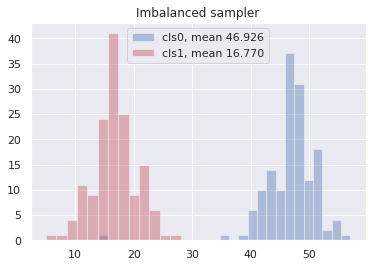

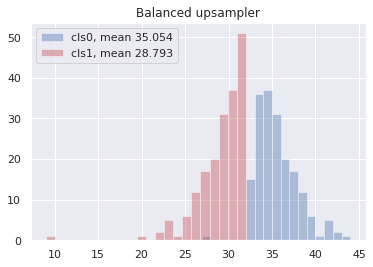

In [12]:
def plot_loader_dist(loader): 
    cls0, cls1 = [], []
    for b in train_dataloader:  
        item = pd.value_counts(b['targets'].detach().cpu().numpy()).values
        if len(item) == 2: 
            cls0.append(item[0]), cls1.append(item[1])
         

    sns.distplot(cls0, kde=False, color="b", label=f'cls0, mean {np.mean(cls0):.3f}')
    sns.distplot(cls1, kde=False, color="r", label=f'cls1, mean {np.mean(cls1):.3f}')
    plt.legend()
    plt.show() 


batch_size = 64

# 1. Bad case
cls_counts = pd.value_counts(answers_train).values 
weights = 1 / torch.tensor(cls_counts).double()

train_sampler = WeightedRandomSampler(weights[answers_train], num_samples=len(answers_train))
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)

plt.title('Imbalanced sampler')
plot_loader_dist(train_dataloader)


# 2. Upsampling mode
train_sampler = BalanceClassSampler(answers_train, mode="upsampling")
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)

plt.title('Balanced upsampler')
plot_loader_dist(train_dataloader)

In [13]:
next(iter(train_dataloader))

{'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'features': tensor([[  101,  2003,  1996,  ...,     0,     0,     0],
         [  101,  2003, 10090,  ...,     0,     0,     0],
         [  101,  2003,  2343,  ...,     0,     0,     0],
         ...,
         [  101,  2003,  9044,  ...,     0,     0,     0],
         [  101,  2515,  2697,  ...,     0,     0,     0],
         [  101,  2515,  5984,  ...,     0,     0,     0]]),
 'targets': tensor([0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0,
         1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,
         1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0])}

In [38]:
class Model(nn.Module): 
    def __init__(self, pretrained_model_name: str):
        super().__init__() 
        self.model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name)

    def n_trainable(self): 
        return sum([params.numel() for name, params in self.model.named_parameters() if params.requires_grad])

    def forward(self, features, attention_mask, targets):
        output = self.model(input_ids=features, 
                            attention_mask=attention_mask,
                            labels=targets)
        logits = output[1]
        return logits 


model = Model(pretrained_model_name)
model.to(device)
print(f'Trainable parameters: {model.n_trainable()}')


Trainable parameters: 125237762


In [0]:
from sklearn.metrics import f1_score, accuracy_score
from catalyst.dl import Callback, CallbackOrder, Runner


class F1ScoreCallback(Callback):
    def __init__(
        self,
        input_key: str = "targets",
        output_key: str = "logits",
        activation: str = "Sigmoid",
        prefix: str = "f1_score",
    ):

        self.prefix = prefix
        self.input_key = input_key
        self.output_key = output_key

        super().__init__(CallbackOrder.Metric)

    def on_batch_end(self, state: Runner):
        y_true = state.input[self.input_key].detach().cpu().numpy()
        logits = state.output[self.output_key].detach().cpu().numpy()
        y_pred = logits.argmax(1)

        score = f1_score(y_true, y_pred)

        state.batch_metrics.update(
            {self.prefix: score}
        )


In [23]:
set_global_seed(33)                       # reproducibility
prepare_cudnn(deterministic=True)           # reproducibility

LOG_DIR = './logs'
epochs = 6
lr = 5e-5                      # learning rate is typically ~1e-5 for transformers
acum_step = 4
num_cls = 2 

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

runner = SupervisedRunner(
    input_key=(
        'features',
        'attention_mask', 
        'targets'
    ),
    device=device
)


# model training
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    loaders=loaders,
    callbacks=[
        AccuracyCallback(num_classes=num_cls),
        F1ScoreCallback(),
        OptimizerCallback(
            accumulation_steps=acum_step, 
            grad_clip_params={'func': 'clip_grad_value_', 'clip_value': 1}
            )
    ],
    main_metric="accuracy01",
    minimize_metric=False,
    # fp16=FP16_PARAMS,
    logdir=LOG_DIR,
    num_epochs=epochs,
    verbose=False, 
    load_best_on_end=True
)

Selected optimization level O0:  Pure FP32 training.

Defaults for this optimization level are:
enabled                : True
opt_level              : O0
cast_model_type        : torch.float32
patch_torch_functions  : False
keep_batchnorm_fp32    : None
master_weights         : False
loss_scale             : 1.0
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O0
cast_model_type        : torch.float32
patch_torch_functions  : False
keep_batchnorm_fp32    : None
master_weights         : False
loss_scale             : 1.0
[2020-06-13 15:13:19,205] 
1/6 * Epoch 1 (_base): lr=4.050e-05 | momentum=0.9000
1/6 * Epoch 1 (train): accuracy01=0.5766 | f1_score=0.5345 | loss=0.6666
1/6 * Epoch 1 (valid): accuracy01=0.6287 | f1_score=0.6537 | loss=0.6518
1/6 * Epoch 1 (test): accuracy01=0.6549 | f1_score=0.6610 | loss=0.6358
[2020-06-13 15:13:19,205] 
1/6 * Epoch 1 (_base)

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



[2020-06-13 15:20:31,941] 
2/6 * Epoch 2 (_base): lr=3.645e-05 | momentum=0.9000
2/6 * Epoch 2 (train): accuracy01=0.7524 | f1_score=0.7320 | loss=0.5140
2/6 * Epoch 2 (valid): accuracy01=0.6916 | f1_score=0.7299 | loss=0.5996
2/6 * Epoch 2 (test): accuracy01=0.7123 | f1_score=0.7439 | loss=0.5813
[2020-06-13 15:20:31,941] 
2/6 * Epoch 2 (_base): lr=3.645e-05 | momentum=0.9000
2/6 * Epoch 2 (train): accuracy01=0.7524 | f1_score=0.7320 | loss=0.5140
2/6 * Epoch 2 (valid): accuracy01=0.6916 | f1_score=0.7299 | loss=0.5996
2/6 * Epoch 2 (test): accuracy01=0.7123 | f1_score=0.7439 | loss=0.5813


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.



[2020-06-13 15:27:42,858] 
3/6 * Epoch 3 (_base): lr=3.281e-05 | momentum=0.9000
3/6 * Epoch 3 (train): accuracy01=0.8825 | f1_score=0.8653 | loss=0.2989
3/6 * Epoch 3 (valid): accuracy01=0.6687 | f1_score=0.6908 | loss=0.8564
3/6 * Epoch 3 (test): accuracy01=0.7022 | f1_score=0.7055 | loss=0.7741
[2020-06-13 15:27:42,858] 
3/6 * Epoch 3 (_base): lr=3.281e-05 | momentum=0.9000
3/6 * Epoch 3 (train): accuracy01=0.8825 | f1_score=0.8653 | loss=0.2989
3/6 * Epoch 3 (valid): accuracy01=0.6687 | f1_score=0.6908 | loss=0.8564
3/6 * Epoch 3 (test): accuracy01=0.7022 | f1_score=0.7055 | loss=0.7741
[2020-06-13 15:34:11,559] 
4/6 * Epoch 4 (_base): lr=2.952e-05 | momentum=0.9000
4/6 * Epoch 4 (train): accuracy01=0.9434 | f1_score=0.9351 | loss=0.1643
4/6 * Epoch 4 (valid): accuracy01=0.7078 | f1_score=0.7391 | loss=0.8782
4/6 * Epoch 4 (test): accuracy01=0.7103 | f1_score=0.7334 | loss=0.8321
[2020-06-13 15:34:11,559] 
4/6 * Epoch 4 (_base): lr=2.952e-05 | momentum=0.9000
4/6 * Epoch 4 (train):

In [0]:
set_global_seed(33)                       # reproducibility
prepare_cudnn(deterministic=True)           # reproducibility

LOG_DIR = './logs'
epochs = 6
lr = 5e-5                      # learning rate is typically ~1e-5 for transformers
acum_step = 4
num_cls = 2 

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

runner = SupervisedRunner(
    input_key=(
        'features',
        'attention_mask', 
        'targets'
    ),
    device=device
)


# model training
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    loaders=loaders,
    callbacks=[
        AccuracyCallback(num_classes=num_cls),
        F1ScoreCallback(),
        OptimizerCallback(
            accumulation_steps=acum_step, 
            grad_clip_params={'func': 'clip_grad_value_', 'clip_value': 1}
            )
    ],
    main_metric="accuracy01",
    minimize_metric=False,
    # fp16=FP16_PARAMS,
    logdir=LOG_DIR,
    num_epochs=epochs,
    verbose=False, 
    load_best_on_end=True
)

Selected optimization level O0:  Pure FP32 training.

Defaults for this optimization level are:
enabled                : True
opt_level              : O0
cast_model_type        : torch.float32
patch_torch_functions  : False
keep_batchnorm_fp32    : None
master_weights         : False
loss_scale             : 1.0
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O0
cast_model_type        : torch.float32
patch_torch_functions  : False
keep_batchnorm_fp32    : None
master_weights         : False
loss_scale             : 1.0


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.



[2020-06-13 16:54:46,860] 
1/6 * Epoch 1 (_base): lr=4.050e-05 | momentum=0.9000
1/6 * Epoch 1 (train): accuracy01=0.5815 | f1_score=0.5069 | loss=0.6718
1/6 * Epoch 1 (valid): accuracy01=0.6705 | f1_score=0.7038 | loss=0.6051
1/6 * Epoch 1 (test): accuracy01=0.7022 | f1_score=0.7338 | loss=0.5956


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



[2020-06-13 17:02:20,022] 
2/6 * Epoch 2 (_base): lr=3.645e-05 | momentum=0.9000
2/6 * Epoch 2 (train): accuracy01=0.7188 | f1_score=0.6798 | loss=0.5643
2/6 * Epoch 2 (valid): accuracy01=0.6920 | f1_score=0.7005 | loss=0.5791
2/6 * Epoch 2 (test): accuracy01=0.6952 | f1_score=0.6994 | loss=0.5783
[2020-06-13 17:09:48,879] 
3/6 * Epoch 3 (_base): lr=3.281e-05 | momentum=0.9000
3/6 * Epoch 3 (train): accuracy01=0.8174 | f1_score=0.7938 | loss=0.4249
3/6 * Epoch 3 (valid): accuracy01=0.7412 | f1_score=0.7656 | loss=0.5872
3/6 * Epoch 3 (test): accuracy01=0.7414 | f1_score=0.7622 | loss=0.5694


In [0]:
%load_ext tensorboard

In [0]:
%tensorboard --logdir $LOG_DIR

In [0]:
torch.cuda.empty_cache()

In [25]:
runner.infer(
    model=model,
    loaders={'test': test_dataloader},
    callbacks=[
        CheckpointCallback(
            resume=f"{LOG_DIR}/checkpoints/best.pth"
        ),
        InferCallback(),
    ],   
    verbose=True
)

Selected optimization level O0:  Pure FP32 training.

Defaults for this optimization level are:
enabled                : True
opt_level              : O0
cast_model_type        : torch.float32
patch_torch_functions  : False
keep_batchnorm_fp32    : None
master_weights         : False
loss_scale             : 1.0
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O0
cast_model_type        : torch.float32
patch_torch_functions  : False
keep_batchnorm_fp32    : None
master_weights         : False
loss_scale             : 1.0
=> Loading checkpoint ./logs/checkpoints/best.pth
loaded state checkpoint ./logs/checkpoints/best.pth (global epoch 5, epoch 5, stage train)
1/1 * Epoch (test): 100% 125/125 [00:08<00:00, 15.07it/s]


In [0]:
predicted_probs = runner.callbacks[0].predictions['logits']

y_preds = predicted_probs.argmax(1)
y_true = np.array(list(map(lambda x: x['targets'], test_dataset)))

In [27]:
from sklearn.metrics import f1_score, accuracy_score

accuracy_score(y_true, y_preds)

0.7464788732394366

In [0]:
inds0 = y_preds == 0
inds1 = y_preds == 1

In [29]:
accuracy_score(y_true[inds0], y_preds[inds0]), accuracy_score(y_true[inds1], y_preds[inds1])

(0.6909090909090909, 0.7740963855421686)